In [1]:
%load_ext autoreload
%autoreload
from IPython.display import clear_output

import os
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

import sys
import subprocess
import pdb
import time
import datetime
import math
import random
import _pickle as cPickle
from collections import defaultdict
import matplotlib.pyplot as plt

%matplotlib inline
# %matplotlib nbagg

from six.moves import zip_longest
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import distributions as tfd
from tensorflow.keras.preprocessing.sequence import pad_sequences

from data_structure import get_batches, get_test_batches
from components import tf_log, sample_latents, compute_kl_loss, dynamic_rnn, dynamic_bi_rnn

from topic_beam_search_decoder import BeamSearchDecoder

In [2]:
PAD = '<pad>' # This has a vocab id, which is used to pad the encoder input, decoder input and target sequence
UNK = '<unk>' # This has a vocab id, which is used to represent out-of-vocabulary words
BOS = '<p>' # This has a vocab id, which is used at the beginning of every decoder input sequence
EOS = '</p>' # This has a vocab id, which is used at the end of untruncated target sequences

# load data & set config

In [3]:
def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()    
    keys_list = [keys for keys in flags_dict]    
    for keys in keys_list:
        FLAGS.__delattr__(keys)

del_all_flags(tf.flags.FLAGS)

flags = tf.app.flags

flags.DEFINE_string('gpu', '4', 'visible gpu')

flags.DEFINE_string('mode', 'train', 'set train or eval')

flags.DEFINE_string('data_path', 'data/synthetic/instances_ncrp_9.pkl', 'path of data')
flags.DEFINE_string('modeldir', 'model/topic_vae', 'directory of model')
flags.DEFINE_string('modelname', 'bags', 'name of model')

flags.DEFINE_integer('epochs', 1000, 'epochs')
flags.DEFINE_integer('batch_size', 64, 'number of sentences in each batch')
flags.DEFINE_integer('log_period', 1000, 'valid period')

flags.DEFINE_string('opt', 'Adagrad', 'optimizer')
# flags.DEFINE_string('opt', 'Adam', 'optimizer')
flags.DEFINE_float('lr', 0.01, 'lr')
flags.DEFINE_float('reg', 10., 'regularization term')
flags.DEFINE_float('grad_clip', 5., 'grad_clip')

flags.DEFINE_float('keep_prob', 0.8, 'dropout rate')
flags.DEFINE_float('word_keep_prob', 0.75, 'word dropout rate')

flags.DEFINE_bool('warmup', True, 'flg of warming up')
flags.DEFINE_integer('epochs_cycle', 5, 'number of epochs within a cycle')
flags.DEFINE_float('r_cycle', 0.5, 'proportion used to increase beta within a cycle')
flags.DEFINE_integer('warmup_topic', 0, 'warmup period for KL of topic')

flags.DEFINE_integer('beam_width', 2, 'beam_width')
flags.DEFINE_float('length_penalty_weight', 0.0, 'length_penalty_weight')

flags.DEFINE_integer('n_topic', 20, 'number of topic')
flags.DEFINE_integer('dim_hidden_bow', 32, 'dim of hidden bow')
flags.DEFINE_integer('dim_latent_bow', 8, 'dim of latent topic')
flags.DEFINE_integer('dim_emb', 32, 'dim_emb')
flags.DEFINE_integer('dim_hidden', 64, 'dim_hidden')
flags.DEFINE_integer('dim_hidden_topic', 64, 'dim_hidden_topic')
flags.DEFINE_integer('dim_latent', 8, 'dim_latent')
flags.DEFINE_bool('bidirectional', True, 'flg of bidirectional encoding')

# for evaluation
flags.DEFINE_string('refdir', 'ref', 'refdir')
flags.DEFINE_string('outdir', 'out', 'outdir')

flags.DEFINE_string('f', '', 'kernel')
flags.DEFINE_bool('logtostderr', True, 'kernel')
flags.DEFINE_bool('showprefixforinfo', False, '')
flags.DEFINE_bool('verbosity', False, '')
# flags.DEFINE_integer('stderrthreshold', 20, 'kernel')

config = flags.FLAGS

flags.DEFINE_string('modelpath', os.path.join(config.modeldir, config.modelname), 'path of model')

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = config.gpu

In [5]:
instances_train, instances_dev, instances_test, word_to_idx, idx_to_word, bow_idxs = cPickle.load(open(config.data_path,'rb'))

In [6]:
instances_train = instances_train[:1000]

In [7]:
def get_batches(instances, batch_size, iterator=False):
    iter_instances = iter(instances)
    n_batch = len(instances)//batch_size
    
    batches = [(i_batch, [next(iter_instances) for i_doc in range(batch_size)]) for i_batch in range(n_batch)]
    
    if iterator: batches = iter(batches)
    return batches

train_batches = get_batches(instances_train, config.batch_size)
dev_batches = get_batches(instances_dev, config.batch_size)
test_batches = get_batches(instances_test, config.batch_size)

In [8]:
flags.DEFINE_integer('n_vocab', len(word_to_idx), 'n_vocab')
flags.DEFINE_integer('dim_bow', len(bow_idxs), 'dim_bow')

flags.DEFINE_integer('cycle_steps', len(train_batches)*config.epochs_cycle, 'number of steps for each cycle')

In [9]:
def debug_shape(variables):
    sample_batch = dev_batches[0][1]
    feed_dict = get_feed_dict(sample_batch)
    _variables = sess.run(variables, feed_dict=feed_dict)
    for _variable, variable in zip(_variables, variables):
        if hasattr(variable, 'name'):
            print(variable.name, ':', _variable.shape)
        else:
            print(_variable.shape)

def debug_value(variables, return_value=False):
    sample_batch = test_batches[0][1]
    feed_dict = get_feed_dict(sample_batch)
    _variables = sess.run(variables, feed_dict=feed_dict)

    if return_value: 
        return _variables
    else:
        for _variable, variable in zip(_variables, variables):
            if hasattr(variable, 'name'):
                print(variable.name, ':', _variable)
            else:
                print(_variable)
                
def check_shape(variables):
    if 'sess' in globals(): raise
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    sample_batch = test_batches[0][1]
    feed_dict = get_feed_dict(sample_batch)
    _variables = sess.run(variables, feed_dict=feed_dict)
    for _variable, variable in zip(_variables, variables):
        if hasattr(variable, 'name'):
            print(variable.name, ':', _variable.shape)
        else:
            print(_variable.shape)
            
    sess.close()
    
def check_value(variables):
    if 'sess' in globals(): raise
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    sample_batch = test_batches[0][1]
    feed_dict = get_feed_dict(sample_batch)
    _variables = sess.run(variables, feed_dict=feed_dict)
    for _variable, variable in zip(_variables, variables):
        if hasattr(variable, 'name'):
            print(variable.name, ':', _variable)
        else:
            print(_variable.shape)
            
    sess.close()    
    

# run model 

## init

In [10]:
def get_feed_dict(batch, mode='train'):
    bow = np.array([instance.bow for instance in batch]).astype(np.float32)
    keep_prob = config.keep_prob if mode == 'train' else 1.0
    feed_dict = {
                t_variables['bow']: bow, 
                t_variables['keep_prob']: keep_prob
    }
    return  feed_dict

In [11]:
tf.reset_default_graph()

def get_depth(parent_idx=0, tree_depth=None, depth=1):
    if tree_depth is None: tree_depth={0: depth}

    child_idxs = tree_idxs[parent_idx]
    depth +=1
    for child_idx in child_idxs:
        tree_depth[child_idx] = depth
        if child_idx in tree_idxs: get_depth(child_idx, tree_depth, depth)
    return tree_depth

t_variables = {}
t_variables['bow'] = tf.placeholder(tf.float32, [None, config.dim_bow])
t_variables['keep_prob'] = tf.placeholder(tf.float32)

# tree_idxs = {0:[1, 2, 3], 
#                       1:[10, 11], 2:[20, 21], 3:[30, 31]}

tree_idxs = {0:[1, 2, 3], 
              1:[10, 11, 12], 2:[20, 21, 22], 3:[30, 31, 32]}

# tree_idxs = {0:[1, 2], 
#              1:[11, 12], 2:[21]}

# tree_idxs = {0:[1, 2, 3], 
#                       1:[10, 11], 2:[20, 21], 3:[30, 31],
#                       10: [100, 101], 11: [110, 111], 20: [200, 201], 21: [210, 211], 30:[300, 301], 31:[310, 311]}

topic_idxs = [0] + [idx for child_idxs in tree_idxs.values() for idx in child_idxs]

child_to_parent_idxs = {child_idx: parent_idx for parent_idx, child_idxs in tree_idxs.items() for child_idx in child_idxs}

tree_depth = get_depth()
max_depth = max(tree_depth.values())

## doubly rnn

In [12]:
class DoublyRNNCell:
    def __init__(self, dim_hidden, output_layer=None):
        self.dim_hidden = dim_hidden
        
        self.ancestral_layer=tf.layers.Dense(units=dim_hidden, activation=tf.nn.tanh, name='ancestral')
        self.fraternal_layer=tf.layers.Dense(units=dim_hidden, activation=tf.nn.tanh, name='fraternal')
        self.hidden_layer = tf.layers.Dense(units=dim_hidden, activation=tf.nn.tanh, name='hidden')
        
        self.output_layer=output_layer
        
    def __call__(self, state_ancestral, state_fraternal, reuse=True):
        with tf.variable_scope('input', reuse=reuse):
            state_ancestral = self.ancestral_layer(state_ancestral)
            state_fraternal = self.fraternal_layer(state_fraternal)

        with tf.variable_scope('output', reuse=reuse):
            state_hidden = self.hidden_layer(state_ancestral + state_fraternal)
            if self.output_layer is not None: 
                output = self.output_layer(state_hidden)
            else:
                output = state_hidden
            
        return output, state_hidden
    
    def get_initial_state(self, name):
        initial_state = tf.get_variable(name, [1, self.dim_hidden], dtype=tf.float32)
        return initial_state
    
    def get_zero_state(self, name):
        zero_state = tf.zeros([1, self.dim_hidden], dtype=tf.float32, name=name)
        return zero_state

In [13]:
def doubly_rnn(dim_hidden, tree_idxs, initial_state_parent=None, initial_state_sibling=None, output_layer=None, name=''):
    outputs, states_parent = {}, {}
    
    with tf.variable_scope(name, reuse=False):
        doubly_rnn_cell = DoublyRNNCell(dim_hidden, output_layer)

        if initial_state_parent is None: 
            initial_state_parent = doubly_rnn_cell.get_initial_state('init_state_parent')
#             initial_state_parent = doubly_rnn_cell.get_zero_state('init_state_parent')
        if initial_state_sibling is None: 
#             initial_state_sibling = doubly_rnn_cell.get_initial_state('init_state_sibling')
            initial_state_sibling = doubly_rnn_cell.get_zero_state('init_state_sibling')
        output, state_sibling = doubly_rnn_cell(initial_state_parent, initial_state_sibling, reuse=False)
        outputs[0], states_parent[0] = output, state_sibling

        for parent_idx, child_idxs in tree_idxs.items():
            state_parent = states_parent[parent_idx]
            state_sibling = initial_state_sibling
            for child_idx in child_idxs:
                output, state_sibling = doubly_rnn_cell(state_parent, state_sibling)
                outputs[child_idx], states_parent[child_idx] = output, state_sibling

    return outputs, states_parent

## stick break

In [14]:
def nCRP(tree_sticks_topic):
    tree_prob_topic = {}
    tree_prob_leaf = {}
    # calculate topic probability and save
    tree_prob_topic[0] = 1.
    
    for parent_idx, child_idxs in tree_idxs.items():
        rest_prob_topic = tree_prob_topic[parent_idx]
        for child_idx in child_idxs:
            stick_topic = tree_sticks_topic[child_idx]
            if child_idx == child_idxs[-1]:
                prob_topic = rest_prob_topic * 1.
            else:
                prob_topic = rest_prob_topic * stick_topic
            
            if not child_idx in tree_idxs: # leaf childs
                tree_prob_leaf[child_idx] = prob_topic
            else:
                tree_prob_topic[child_idx] = prob_topic
                
            rest_prob_topic -= prob_topic
            
    return tree_prob_leaf

def get_ancestor_idxs(leaf_idx, ancestor_idxs = None):
    if ancestor_idxs is None: ancestor_idxs = [leaf_idx]
    
    parent_idx = child_to_parent_idxs[leaf_idx]
    ancestor_idxs += [parent_idx]
    if parent_idx in child_to_parent_idxs: get_ancestor_idxs(parent_idx, ancestor_idxs)
    return ancestor_idxs[::-1]

def get_prob_topic(tree_prob_leaf, prob_depth):
    tree_prob_topic = defaultdict(float)
    
    leaf_ancestor_idxs = {leaf_idx: get_ancestor_idxs(leaf_idx) for leaf_idx in tree_prob_leaf}
    for leaf_idx, ancestor_idxs in leaf_ancestor_idxs.items():
        prob_leaf = tree_prob_leaf[leaf_idx]
        for i, ancestor_idx in enumerate(ancestor_idxs):
            prob_ancestor = prob_leaf * tf.expand_dims(prob_depth[:, i], -1)
            tree_prob_topic[ancestor_idx] += prob_ancestor
    prob_topic = tf.concat([tree_prob_topic[topic_idx] for topic_idx in topic_idxs], -1)
    return prob_topic

## build model

In [15]:
def get_tree_topic_bow(tree_topic_embeddings):
    def softmax_with_temperature(logits, axis=None, name=None, temperature=1.):
        if axis is None:
            axis = -1
        return tf.exp(logits / temperature) / tf.reduce_sum(tf.exp(logits / temperature), axis=axis)

    tree_topic_bow = {}
    for topic_idx, depth in tree_depth.items():
        topic_embedding = tree_topic_embeddings[topic_idx]
        temperature = tf.constant(10. * (10 ** (1./depth)), dtype=tf.float32)
        logits = tf.matmul(topic_embedding, bow_embeddings, transpose_b=True)
        tree_topic_bow[topic_idx] = softmax_with_temperature(logits, axis=-1, temperature=temperature)
    
    return tree_topic_bow

In [16]:
# encode bow
with tf.variable_scope('topic/enc', reuse=False):
    hidden_bow_ = tf.layers.Dense(units=config.dim_hidden_bow, activation=tf.nn.tanh, name='hidden_bow')(t_variables['bow'])
    hidden_bow = tf.layers.Dropout(t_variables['keep_prob'])(hidden_bow_)
    means_bow = tf.layers.Dense(units=config.dim_latent_bow, name='mean_bow')(hidden_bow)
    logvars_bow = tf.layers.Dense(units=config.dim_latent_bow, kernel_initializer=tf.constant_initializer(0), bias_initializer=tf.constant_initializer(0), name='logvar_bow')(hidden_bow)
    latents_bow = sample_latents(means_bow, logvars_bow) # sample latent vectors
    prob_layer = lambda h: tf.nn.sigmoid(tf.matmul(latents_bow, h, transpose_b=True))
    
    tree_sticks_topic, tree_states_sticks_topic = doubly_rnn(config.dim_latent_bow, tree_idxs, output_layer=prob_layer, name='sticks_topic')
    tree_prob_leaf = nCRP(tree_sticks_topic)
    prob_depth = tf.layers.Dense(units=max_depth, activation=tf.nn.softmax, name='prob_topic')(latents_bow) # inference of topic probabilities
    
    prob_topic = get_prob_topic(tree_prob_leaf, prob_depth)

# decode bow
with tf.variable_scope('shared', reuse=False):
    embeddings = tf.get_variable('emb', [config.n_vocab, config.dim_emb], dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer()) # embeddings of vocab

bow_embeddings = tf.nn.embedding_lookup(embeddings, bow_idxs) # embeddings of each bow features

with tf.variable_scope('topic/dec', reuse=False):
    emb_layer = tf.layers.Dense(units=config.dim_emb, name='output')
    tree_topic_embeddings, tree_states_topic_embeddings = doubly_rnn(config.dim_emb, tree_idxs, output_layer=emb_layer, name='emb_topic')
#     topic_embeddings = tf.get_variable('topic_emb', [len(topic_idxs), config.dim_emb], dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer()) # embeddings of topics
#     tree_topic_embeddings = {topic_idx: tf.expand_dims(topic_embeddings[topic_idxs.index(topic_idx)], 0) for topic_idx in topic_idxs}

    tree_topic_bow = get_tree_topic_bow(tree_topic_embeddings) # bow vectors for each topic
    
    topic_bow = tf.concat([tree_topic_bow[topic_idx] for topic_idx in topic_idxs], 0)
    logits_bow = tf_log(tf.matmul(prob_topic, topic_bow)) # predicted bow distribution

## define loss

In [17]:
def get_tree_mask_reg(tree_idxs):
    tree_mask_reg = np.ones([len(topic_idxs), len(topic_idxs)], dtype=np.float32)
    parent_to_descendant_idxs = {parent_idx: get_descendant_idxs(parent_idx) for parent_idx in tree_idxs}
    
    for parent_idx, descendant_idxs in parent_to_descendant_idxs.items():
        for descendant_idx in descendant_idxs:
            tree_mask_reg[topic_idxs.index(parent_idx), topic_idxs.index(descendant_idx)] = tree_mask_reg[topic_idxs.index(descendant_idx), topic_idxs.index(parent_idx)] = 0.
            
    return tree_mask_reg

def get_depth_mask_reg(tree_idxs):
    depth_mask_reg = np.zeros([len(topic_idxs), len(topic_idxs)], dtype=np.float32)
    
    depth_mask_reg[0, 0] = 1.
    for parent_idx, child_idxs in tree_idxs.items():
        for child_idx1 in child_idxs:
            for child_idx2 in child_idxs:
                depth_mask_reg[topic_idxs.index(child_idx1), topic_idxs.index(child_idx2)] = 1.
                
    return depth_mask_reg

def get_descendant_idxs(parent_idx, descendant_idxs = None):
    if descendant_idxs is None: descendant_idxs = []
    
    child_idxs = tree_idxs[parent_idx]
    descendant_idxs += child_idxs
    for child_idx in child_idxs:
        if child_idx in tree_idxs: get_descendant_idxs(child_idx, descendant_idxs)
    return descendant_idxs

In [18]:
# define losses
topic_losses_recon = -tf.reduce_sum(tf.multiply(t_variables['bow'], logits_bow), 1)
topic_loss_recon = tf.reduce_mean(topic_losses_recon) # negative log likelihood of each words

topic_loss_kl = compute_kl_loss(means_bow, logvars_bow) # KL divergence b/w latent dist & gaussian std

topic_bow_norm = topic_bow / tf.norm(topic_bow, axis=1, keepdims=True)
topic_dots = tf.clip_by_value(tf.matmul(topic_bow_norm, tf.transpose(topic_bow_norm)), -1., 1.)
# topic_loss_reg = tf.reduce_mean(tf.square(topic_dots - tf.eye(len(topic_idxs))))
tree_mask_reg = get_tree_mask_reg(tree_idxs)
# tree_mask_reg = get_depth_mask_reg(tree_idxs)
topic_losses_reg = tf.square(topic_dots - tf.eye(len(topic_idxs))) * tree_mask_reg
topic_loss_reg = tf.reduce_sum(topic_losses_reg) / tf.reduce_sum(tree_mask_reg)

# topic_embeddings = tf.concat([tree_topic_embeddings[topic_idx] for topic_idx in topic_idxs], 0)
# topic_embeddings_norm = topic_embeddings / tf.norm(topic_embeddings, axis=1, keepdims=True)
# topic_dots = tf.clip_by_value(tf.matmul(topic_embeddings_norm, tf.transpose(topic_embeddings_norm)), -1., 1.)
# tree_mask_reg = get_tree_mask_reg(tree_idxs)
# topic_loss_reg = tf.reduce_sum(tf.square(topic_dots - tf.eye(len(topic_idxs))) * tree_mask_reg) / tf.reduce_sum(tree_mask_reg)

# topic_embeddings = tf.concat([tree_topic_embeddings[topic_idx] for topic_idx in topic_idxs], 0)
# topic_embeddings_norm = topic_embeddings / tf.norm(topic_embeddings, axis=1, keepdims=True)
# topic_dots = tf.clip_by_value(tf.matmul(topic_embeddings_norm, tf.transpose(topic_embeddings_norm)), -1., 1.)
# topic_angles = tf.acos(topic_dots)
# tree_mask_reg = get_tree_mask_reg(tree_idxs)

# mean_angles = tf.reduce_sum(topic_angles*tree_mask_reg) / tf.reduce_sum(tree_mask_reg)
# var_angles = tf.reduce_sum(tf.square(topic_angles-mean_angles)*tree_mask_reg) / tf.reduce_sum(tree_mask_reg)
# mean_angles = tf.reduce_mean(topic_angles)
# var_angles = tf.reduce_mean(tf.square(topic_angles-mean_angles))
# mean_angles = tf.asin(tf.sqrt(tf.linalg.det(topic_dots * tree_mask_reg)))
# var_angles = tf.square(tf.constant(np.pi/2., dtype=tf.float32)-mean_angles)

# topic_loss_reg = var_angles - mean_angles

global_step = tf.Variable(0, name='global_step',trainable=False)

loss = topic_loss_recon + topic_loss_kl + config.reg * topic_loss_reg

# define optimizer
if config.opt == 'Adam':
    optimizer = tf.train.AdamOptimizer(config.lr)
elif config.opt == 'Adagrad':
    optimizer = tf.train.AdagradOptimizer(config.lr)

grad_vars = optimizer.compute_gradients(loss)
clipped_grad_vars = [(tf.clip_by_value(grad, -config.grad_clip, config.grad_clip), var) for grad, var in grad_vars]
opt = optimizer.apply_gradients(clipped_grad_vars, global_step=global_step)

# monitor
n_bow = tf.reduce_sum(t_variables['bow'], 1)
topic_ppls = tf.divide(topic_losses_recon, tf.maximum(1e-5, n_bow))
topics_freq_bow_indices = tf.nn.top_k(topic_bow, 5, name='topic_freq_bow').indices

In [19]:
def get_loss(sess, batches):
    losses = []
    ppl_list = []
    for ct, batch in batches:
        feed_dict = get_feed_dict(batch, mode='test')
        loss_batch, topic_loss_recon_batch, topic_loss_kl_batch, topic_loss_reg_batch, ppls_batch \
            = sess.run([loss, topic_loss_recon, topic_loss_kl, topic_loss_reg, topic_ppls], feed_dict = feed_dict)
        losses += [[loss_batch, topic_loss_recon_batch, topic_loss_kl_batch, topic_loss_reg_batch]]
        ppl_list += list(ppls_batch)
    loss_mean, topic_loss_recon_mean, topic_loss_kl_mean, topic_loss_reg_mean = np.mean(losses, 0)
    ppl_mean = np.exp(np.mean(ppl_list))
    return loss_mean, topic_loss_recon_mean, topic_loss_kl_mean, topic_loss_reg_mean, ppl_mean

In [20]:
from matplotlib.colors import Normalize # Normalizeをimport

def print_topic_sample():
    _topics_bow = sess.run(topic_bow)
    plt.figure(figsize=(9, 15))
    
    _topic_bow = _topics_bow[0]
    plt.subplot(5,3,2)
    plt.axis('off')
    plt.title(topic_idxs[0])
    plt.imshow(_topic_bow.reshape(int(config.n_vocab**(1/2)), int(config.n_vocab**(1/2))), cmap='Wistia', norm=Normalize(vmin=0., vmax=0.3))
    
    for i in range(1, len(topic_idxs)):
        _topic_bow = _topics_bow[i]
        plt.subplot(5,3,i+3)
        plt.axis('off')
        plt.title(topic_idxs[i])
        plt.imshow(_topic_bow.reshape(int(config.n_vocab**(1/2)), int(config.n_vocab**(1/2))), cmap='Wistia', norm=Normalize(vmin=0., vmax=0.3))
        
    plt.show()

In [21]:
if 'sess' in globals(): sess.close()
sess = tf.Session(config=tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1))
sess.run(tf.global_variables_initializer())

losses_train = []
ppls_train = []
loss_min = np.inf
beta_eval = 1.
epoch = 0
train_batches = get_batches(instances_train, config.batch_size, iterator=True)
saver = tf.train.Saver(max_to_keep=10)

log_df = pd.DataFrame(columns=pd.MultiIndex.from_tuples(
                    list(zip(*[['','','','TRAIN:','TM','','','','VALID:','TM','','',''],
                            ['Time','Ep','Ct','LOSS','PPL','NLL','KL','REG','LOSS','PPL','NLL','KL','REG']]))))

TRAIN:  TM                      VALID:  TM                \
      Time   Ep  Ct    LOSS PPL     NLL    KL   REG    LOSS PPL     NLL    KL   
1000    13   66   9  216.74   9  214.87  1.06  0.81  214.47   8  211.97  1.88   
2000    11  133   4  214.99   8  212.76  1.54  0.69  212.70   8  210.07  2.10   
3000    11  199  14  214.03   8  211.67  1.75  0.61  211.72   8  209.04  2.26   
4000    11  266   9  213.39   8  210.95  1.88  0.56  211.30   8  208.62  2.30   
5000    11  333   4  212.95   8  210.47  1.96  0.52  211.13   8  208.45  2.32   
6000    11  399  14  212.63   8  210.12  2.01  0.49  211.03   8  208.36  2.32   
7000    11  466   9  212.40   8  209.87  2.06  0.47  210.97   8  208.34  2.31   
8000    11  533   4  212.21   8  209.67  2.09  0.45  210.91   8  208.28  2.31   
9000    11  599  14  212.06   8  209.51  2.12  0.44  210.88   8  208.25  2.31   
10000   11  666   9  211.94   8  209.38  2.14  0.43  210.91   8  208.25  2.34   
11000   11  733   4  211.84   8  209.27  2.15  0.42  210.80   8  208.17  2.31   
12000   11  799  14  211.75   8  209.18  2.17  0.41  210.76   8  208.12  2.33   
13000   11  866   9  211.68   8  209.10  2.18  0.40  210.86   8  208.23  2.32   
14000   11  933   4  211.62   8  209.03  2.19  0.39  210.79   8  208.15  2.33   
15000   11  999  14  211.56   8  208.97  2.20  0.39  210.78   8  208.14  2.33   

             
        REG  
1000   0.62  
2000   0.52  
3000   0.42  
4000   0.38  
5000   0.36  
6000   0.34  
7000   0.33  
8000   0.33  
9000   0.32  
10000  0.32  
11000  0.32  
12000  0.31  
13000  0.31  
14000  0.31  
15000  0.31

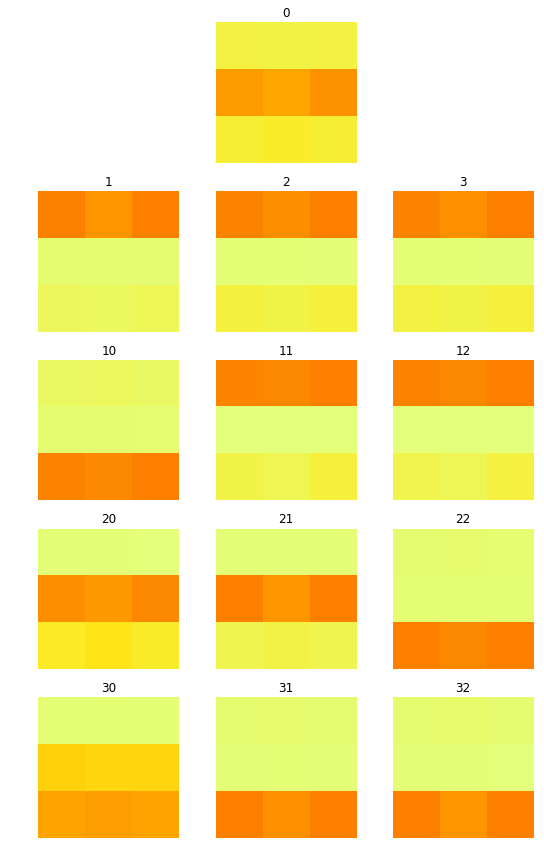

TRAIN:  TM                      VALID:  TM                \
      Time   Ep  Ct    LOSS PPL     NLL    KL   REG    LOSS PPL     NLL    KL   
1000    13   66   9  216.74   9  214.87  1.06  0.81  214.47   8  211.97  1.88   
2000    11  133   4  214.99   8  212.76  1.54  0.69  212.70   8  210.07  2.10   
3000    11  199  14  214.03   8  211.67  1.75  0.61  211.72   8  209.04  2.26   
4000    11  266   9  213.39   8  210.95  1.88  0.56  211.30   8  208.62  2.30   
5000    11  333   4  212.95   8  210.47  1.96  0.52  211.13   8  208.45  2.32   
6000    11  399  14  212.63   8  210.12  2.01  0.49  211.03   8  208.36  2.32   
7000    11  466   9  212.40   8  209.87  2.06  0.47  210.97   8  208.34  2.31   
8000    11  533   4  212.21   8  209.67  2.09  0.45  210.91   8  208.28  2.31   
9000    11  599  14  212.06   8  209.51  2.12  0.44  210.88   8  208.25  2.31   
10000   11  666   9  211.94   8  209.38  2.14  0.43  210.91   8  208.25  2.34   
11000   11  733   4  211.84   8  209.27  2.15  0.42  210.80   8  208.17  2.31   
12000   11  799  14  211.75   8  209.18  2.17  0.41  210.76   8  208.12  2.33   
13000   11  866   9  211.68   8  209.10  2.18  0.40  210.86   8  208.23  2.32   
14000   11  933   4  211.62   8  209.03  2.19  0.39  210.79   8  208.15  2.33   
15000   11  999  14  211.56   8  208.97  2.20  0.39  210.78   8  208.14  2.33   

             
        REG  
1000   0.62  
2000   0.52  
3000   0.42  
4000   0.38  
5000   0.36  
6000   0.34  
7000   0.33  
8000   0.33  
9000   0.32  
10000  0.32  
11000  0.32  
12000  0.31  
13000  0.31  
14000  0.31  
15000  0.31

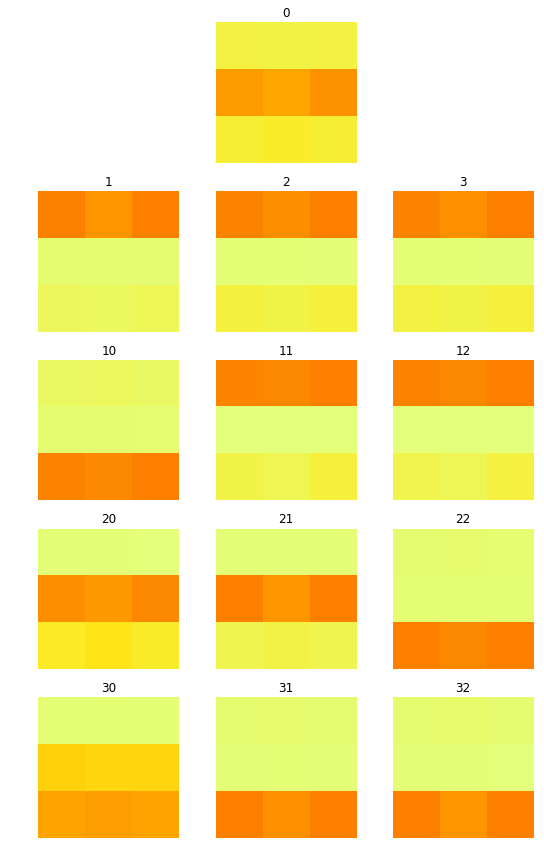

In [22]:
if len(log_df) == 0:
    cmd_rm = 'rm -r %s' % config.modeldir
    res = subprocess.call(cmd_rm.split())

    cmd_mk = 'mkdir %s' % config.modeldir
    res = subprocess.call(cmd_mk.split())

time_start = time.time()
while epoch < config.epochs:
    for ct, batch in train_batches:
        feed_dict = get_feed_dict(batch)

        _, loss_batch, topic_loss_recon_batch, topic_loss_kl_batch, topic_loss_reg_batch, ppls_batch, global_step_log = \
        sess.run([opt, loss, topic_loss_recon, topic_loss_kl, topic_loss_reg, topic_ppls, tf.train.get_global_step()], feed_dict = feed_dict)

        losses_train += [[loss_batch, topic_loss_recon_batch, topic_loss_kl_batch, topic_loss_reg_batch]]
        ppls_train += list(ppls_batch)

        if global_step_log%config.log_period==0:
            loss_train, topic_loss_recon_train, topic_loss_kl_train, topic_loss_reg_train = np.mean(losses_train, 0)
            ppl_train = np.exp(np.mean(ppls_train))
            loss_dev, topic_loss_recon_dev, topic_loss_kl_dev, topic_loss_reg_dev, ppl_dev = get_loss(sess, dev_batches)
            
#             if loss_dev < loss_min:
#                 loss_min = loss_dev
#                 saver.save(sess, config.modelpath, global_step=global_step_log)

            clear_output()
    
            time_log = int(time.time() - time_start)
            log_series = pd.Series([time_log, epoch, ct, \
                    '%.2f'%loss_train, '%.0f'%ppl_train, '%.2f'%topic_loss_recon_train, '%.2f'%topic_loss_kl_train, '%.2f'%topic_loss_reg_train, \
                    '%.2f'%loss_dev, '%.0f'%ppl_dev, '%.2f'%topic_loss_recon_dev, '%.2f'%topic_loss_kl_dev, '%.2f'%topic_loss_reg_dev],
                    index=log_df.columns)
            log_df.loc[global_step_log] = log_series
            display(log_df)
            
            # visualize topic
            print_topic_sample()

            time_start = time.time()
            
    epoch += 1
    train_batches = get_batches(instances_train, config.batch_size, iterator=True)
    
display(log_df)
print_topic_sample()

# confirm variables

In [23]:
states_topic_embeddings = tf.concat([tree_states_topic_embeddings[topic_idx] for topic_idx in topic_idxs], 0)

In [24]:
debug_value([states_topic_embeddings[:, :6]])

strided_slice:0 : [[-0.9898385   0.64211136 -0.1754918  -0.99638575 -0.9896069   0.98456866]
 [ 0.9960431  -0.9819608   0.64303744  0.9964002  -0.2530598  -0.8326717 ]
 [ 0.999796   -0.68278956  0.47235     0.99989533  0.9013988  -0.97732645]
 [ 0.9999866  -0.9852764   0.5409591   0.9999801   0.8768079  -0.93803763]
 [-0.858994    0.14576772 -0.60588366 -0.95108     0.94144017 -0.87347245]
 [ 0.9405421  -0.95263743  0.5902808   0.7950804   0.99636596 -0.99937516]
 [ 0.9842963  -0.7348778  -0.3949933   0.9581794   0.9988755  -0.9966899 ]
 [-0.9992913   0.9968274  -0.98239267 -0.999683    0.7499069   0.88019365]
 [-0.9998502   0.9066039  -0.9307112  -0.99993384  0.23115653  0.9240346 ]
 [-0.99925035  0.95966446 -0.93203014 -0.99979144  0.9495025  -0.7706108 ]
 [-0.99874777  0.9963412  -0.98017865 -0.9991353   0.8905799   0.63794607]
 [-0.9959714   0.8760052  -0.8730173  -0.99795     0.98585117 -0.72815174]
 [-0.96534866  0.95109093 -0.93135667 -0.9579316   0.998647   -0.9889365 ]]


In [25]:
topic_embeddings = tf.concat([tree_topic_embeddings[topic_idx] for topic_idx in topic_idxs], 0)

In [26]:
debug_value([topic_embeddings[:, :6]])

strided_slice_1:0 : [[ 8.39822006e+00  3.99098545e-03 -6.54287243e+00 -8.64249039e+00
  -5.01265860e+00  1.15229845e+01]
 [-1.96424139e+00  4.96738482e+00  9.31883049e+00  3.06710553e+00
   7.72428751e+00 -4.97641373e+00]
 [-4.52829552e+00  1.26872826e+00  8.77968884e+00  5.64823437e+00
   6.88577318e+00 -9.13713455e+00]
 [-4.48960304e+00  1.54657197e+00  8.83346272e+00  5.48249388e+00
   7.08297157e+00 -8.56632710e+00]
 [-4.41065836e+00 -6.78359890e+00 -3.64493489e+00  1.24908423e+00
  -3.22116661e+00 -9.83054399e-01]
 [-5.77867603e+00  1.85164839e-01  7.71494198e+00  6.06260729e+00
   5.53584623e+00 -8.98149967e+00]
 [-6.04829645e+00  1.95413619e-01  8.21665096e+00  5.97709465e+00
   6.07224226e+00 -9.65100574e+00]
 [ 1.88749707e+00 -5.80868196e+00 -9.80365276e+00 -4.02250242e+00
  -7.79182959e+00  6.02152014e+00]
 [ 2.06249380e+00 -3.22978497e+00 -8.43324089e+00 -4.78851080e+00
  -6.71297407e+00  7.71905518e+00]
 [-5.41162157e+00 -8.46052074e+00 -5.59605742e+00  1.10916245e+00
  -4.

In [27]:
_topics_bow, = debug_value([topic_bow], return_value=True)
np.max(_topics_bow)

0.3768517

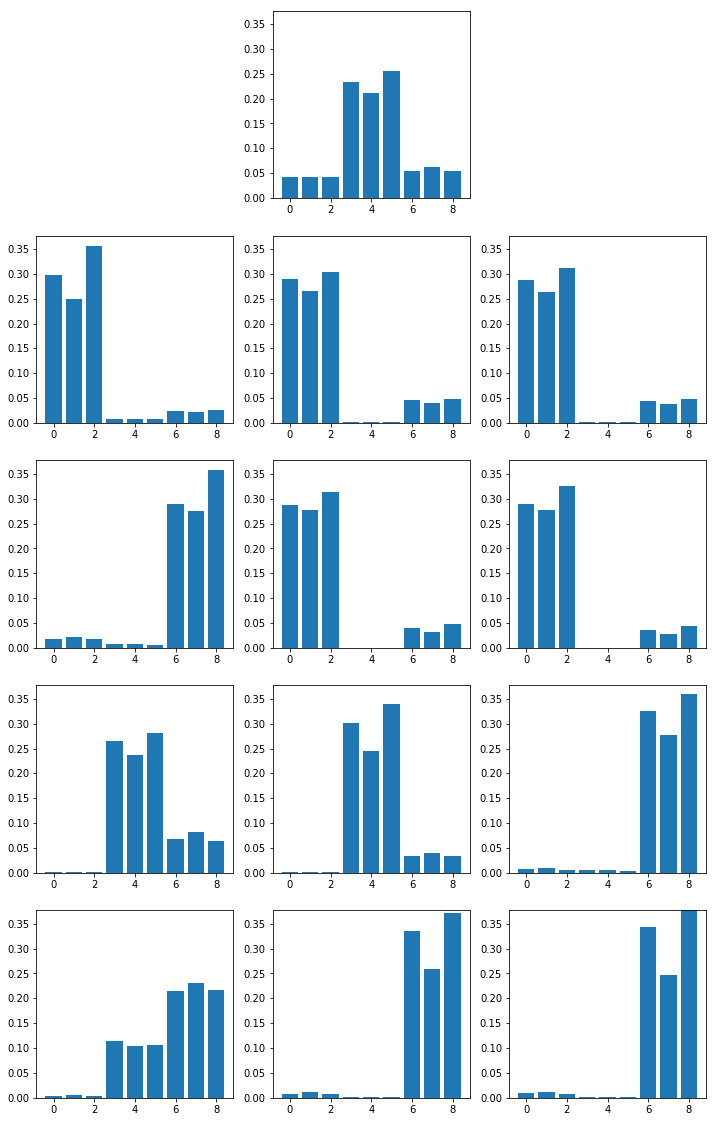

In [28]:
_topics_bow, = debug_value([topic_bow], return_value=True)

plt.figure(figsize=(12, 20))
    
_topic_bow = _topics_bow[0]
plt.subplot(5,3,2)
plt.ylim([0, np.max(_topics_bow)])
plt.bar(bow_idxs, _topic_bow)

for i in range(1, len(topic_idxs)):
    _topic_bow = _topics_bow[i]
    plt.subplot(5,3,i+3)
    plt.ylim([0, np.max(_topics_bow)])
#     plt.axis('off')
    plt.bar(bow_idxs, _topic_bow)

plt.show()

In [29]:
_prob_topics = []
for ct, batch in dev_batches:
    feed_dict = get_feed_dict(batch)
    _prob_topic, = sess.run([prob_topic], feed_dict = feed_dict)
    _prob_topics.append(_prob_topic)
    
_prob_topics = np.concatenate(_prob_topics, 0)
_prob_topic_mean = np.mean(_prob_topics, 0)

print(_prob_topic_mean)

[0.20471583 0.1310653  0.0379467  0.03415927 0.1064275  0.05136224
 0.07556961 0.06710622 0.03089777 0.04595589 0.09186313 0.0436862
 0.07924435]


In [30]:
debug_value([topic_dots])

clip_by_value:0 : [[1.         0.21535766 0.21543373 0.21392684 0.2627024  0.20334698
  0.20016356 0.98520064 0.9771674  0.24947962 0.6332634  0.24096167
  0.2369319 ]
 [0.21535766 1.         0.9930388  0.99467313 0.14223629 0.99385786
  0.9957912  0.05133982 0.04045141 0.10392651 0.09948    0.10724013
  0.10869181]
 [0.21543373 0.9930388  0.9999999  0.9998463  0.21681416 0.99946374
  0.9988727  0.05330392 0.03154228 0.17872535 0.15830676 0.18215975
  0.18361026]
 [0.21392684 0.99467313 0.9998463  1.         0.21233067 0.9995287
  0.9992829  0.05165622 0.03058057 0.17415527 0.15390846 0.17762566
  0.1790857 ]
 [0.2627024  0.14223629 0.21681416 0.21233067 1.         0.19843087
  0.18451315 0.27724448 0.13916695 0.99768543 0.89752346 0.9961661
  0.9940027 ]
 [0.20334698 0.99385786 0.99946374 0.9995287  0.19843087 0.99999994
  0.9997577  0.03998328 0.02108249 0.15987559 0.13666    0.16379899
  0.16550821]
 [0.20016356 0.9957912  0.9988727  0.9992829  0.18451315 0.9997577
  1.         0.03

In [31]:
debug_value([topic_losses_reg])

mul_2:0 : [[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 9.8612601e-01 9.8937464e-01 0.0000000e+00
  0.0000000e+00 0.0000000e+00 2.6357775e-03 1.6363170e-03 1.0800719e-02
  9.8962700e-03 1.1500444e-02 1.1813910e-02]
 [0.0000000e+00 9.8612601e-01 1.4210855e-14 9.9969256e-01 4.7008380e-02
  9.9892777e-01 9.9774665e-01 0.0000000e+00 0.0000000e+00 0.0000000e+00
  2.5061032e-02 3.3182174e-02 3.3712726e-02]
 [0.0000000e+00 9.8937464e-01 9.9969256e-01 0.0000000e+00 4.5084313e-02
  9.9905765e-01 9.9856633e-01 2.6683647e-03 9.3517121e-04 3.0330056e-02
  0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 4.7008380e-02 4.5084313e-02 0.0000000e+00
  3.9374810e-02 3.4045104e-02 7.6864503e-02 1.9367440e-02 9.9537623e-01
  8.0554837e-01 9.9234694e-01 9.8804134e-01]
 [0.0000000e+00 0.0000000e+00 9.9892777e-01 9

In [32]:
tree_mask_reg

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],
      dtype=float32)

In [33]:
_topic_bow, = debug_value([topic_bow], return_value=True)

<BarContainer object of 9 artists>

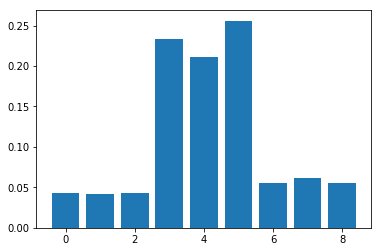

In [34]:
plt.bar(bow_idxs, _topic_bow[0])

<BarContainer object of 9 artists>

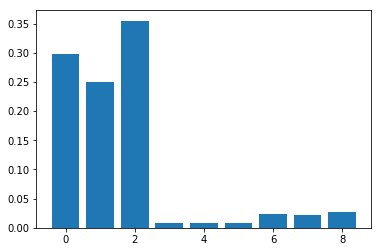

In [35]:
plt.bar(bow_idxs, _topic_bow[1])

<BarContainer object of 9 artists>

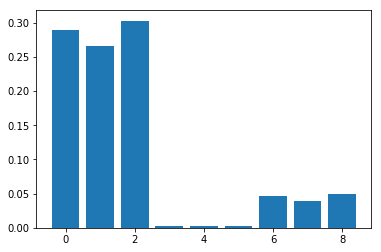

In [36]:
plt.bar(bow_idxs, _topic_bow[2])

<BarContainer object of 9 artists>

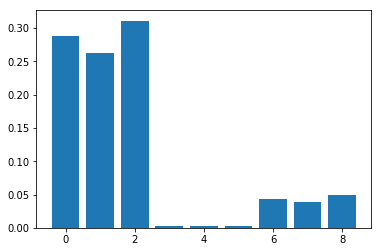

In [37]:
plt.bar(bow_idxs, _topic_bow[3])

In [38]:
np.max(_topic_bow, 1)

array([0.2559171 , 0.35493204, 0.30284756, 0.31103218, 0.35728914,
       0.31386957, 0.32497   , 0.2812065 , 0.34034967, 0.35863882,
       0.2310702 , 0.37132648, 0.3768517 ], dtype=float32)

<BarContainer object of 9 artists>

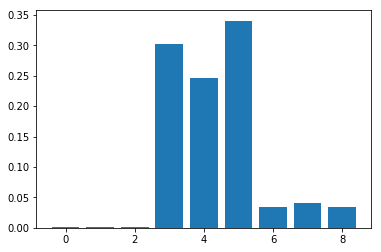

In [39]:
plt.bar(bow_idxs, _topic_bow[-5])

<BarContainer object of 9 artists>

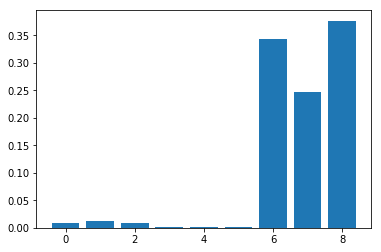

In [40]:
plt.bar(bow_idxs, _topic_bow[-1])

In [41]:
len(bow_idxs)

9

In [42]:
debug_value([prob_topic[3]])

strided_slice_2:0 : [1.4300756e-01 7.1376073e-01 3.4302559e-02 4.1506663e-02 4.4705629e-02
 8.4201694e-03 7.8231785e-03 1.7601268e-03 6.5452675e-04 5.1448785e-04
 2.2161303e-03 8.7388180e-04 4.5429668e-04]


In [43]:
debug_value([tf.exp(-tf.divide(topic_losses_recon, n_bow))])

Exp_1:0 : [0.12220112 0.12987882 0.13047731 0.15169969 0.14337999 0.1260815
 0.1245105  0.11700626 0.11682452 0.12122644 0.11023413 0.14049484
 0.1707343  0.11495777 0.13653646 0.13698931 0.1156252  0.11240815
 0.11549827 0.12002106 0.13676968 0.11757219 0.152172   0.16163155
 0.12611443 0.13711774 0.13460799 0.1113361  0.11322401 0.12627803
 0.12116376 0.11731886 0.11678686 0.14294289 0.11386965 0.1099771
 0.13070078 0.11649775 0.11851206 0.12034791 0.11794113 0.11933422
 0.12448293 0.12459474 0.11841663 0.16698842 0.11092032 0.12410651
 0.12609845 0.13981187 0.13996139 0.12913336 0.14343211 0.13023949
 0.11173353 0.1183363  0.12991387 0.11753312 0.10919007 0.1158208
 0.10889377 0.11869133 0.11143317 0.14610071]


### test

In [44]:
debug_shape([bow, hidden_bow, latents_bow, prob_topic, bow_embeddings, topic_embeddings, topic_bow, prob_bow])

NameError: name 'bow' is not defined

In [ ]:
debug_shape([topic_losses_recon, topic_loss_recon, n_bow, ppls, topic_embeddings_norm, tf.expand_dims(topic_angles_mean, -1), topic_angles_vars])

In [ ]:
debug_value([tf.reduce_sum(tf.square(topic_embeddings_norm), 1)], return_value=True)[0]

In [ ]:
debug_value([tf.reduce_sum(prob_topic, -1), tf.reduce_sum(topic_bow, -1), tf.reduce_sum(tf.exp(prob_bow), 1)])

In [ ]:
sigma_bow = tf.exp(0.5 * logvars_bow)
dist_bow = tfd.Normal(means_bow, sigma_bow)
dist_std = tfd.Normal(0., 1.)
topic_loss_kl_tmp = tf.reduce_mean(tf.reduce_sum(tfd.kl_divergence(dist_bow, dist_std), 1))

In [ ]:
debug_value([topic_loss_recon, topic_loss_kl, topic_loss_kl_tmp])

In [ ]:
_logvars, _means, _kl_losses, _latents, _output_logits = sess.run([logvars, means, kl_losses, latents, output_logits], feed_dict=feed_dict)


In [ ]:
_logvars.shape, _means.shape, _kl_losses.shape, _latents.shape

In [ ]:
_output_logits

In [ ]:
_output_logits, _dec_target_idxs_do, _dec_mask_tokens_do, _recon_loss, _kl_losses, _ = sess.run([output_logits, dec_target_idxs_do, dec_mask_tokens_do, recon_loss, kl_losses, opt], feed_dict=feed_dict)


In [ ]:
tf.reduce_max(output_logits, 2).eval(session=sess, feed_dict=feed_dict).shape

In [ ]:
_output_logits.shape, _dec_target_idxs_do.shape, _dec_mask_tokens_do.shape

In [ ]:
_logits = np.exp(_output_logits) / np.sum(np.exp(_output_logits), 2)[:, :, None]

In [ ]:
_idxs = _dec_target_idxs_do

In [ ]:
_losses = np.array([[-np.log(_logits[i, j, _idxs[i, j]]) for j in range(_idxs.shape[1])] for i in range(_idxs.shape[0])]) * _dec_mask_tokens_do

In [ ]:
np.sum(_losses)/np.sum(_dec_mask_tokens_do)

In [ ]:
_recon_loss

In [ ]:
_kl_losses.shape